# NOTES:
* See notes form file 02 (run_group_ICA) (just look at the most updated version of it). Some notes are VERY relevant.

* Look at NEXT: note at the bottom of this page.

* pip install git+https://git.fmrib.ox.ac.uk/fsl/fslnets.git
Needed to be run to use this


# Import stuff + params

In [1]:
from fsl import nets
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# need to set up to run fsl.
os.environ['FSLDIR'] = '/export/home/ranigera/fsl'
os.environ['PATH'] += ':/export/home/ranigera/fsl/bin'

group_ICA_path = '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA'

whole_network_path = '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks'

# n_ICs = 50 # number of independent components

# R01 to IDCH mapping:
mapping_R01_to_IDCH = {'222': '101', '183': '102', '216': '103', '192': '104', '251': '105', '206': '106', '180': '107', '184': '108', '169': '109', '207': '110',
                       '159': '111', '115': '112', '114': '113', '232': '114', '173': '115', '171': '117', '215': '118', '265': '119', '177': '120', '269': '121',
                       '261': '122'}

main_behav_file = '/export/home/ranigera/IDCH-rsfMRI/data/behav_data/merged_behav_data.csv'

In [2]:
n_ICs=50 # number of independent components
# run slices_summary:
# check if exists:
if not os.path.exists(f'{group_ICA_path}/groupICA{n_ICs}.sum'):
    os.system(f'slices_summary {group_ICA_path}/groupICA{n_ICs}/melodic_IC 4 $FSLDIR/data/standard/MNI152_T1_2mm {group_ICA_path}/groupICA{n_ICs}.sum -1')


## Copy the time series to a dedicated folder and assign the right subject (IDCH) number

In [3]:
n_ICs=50 # number of independent components

by_IDCH_sub_ID_ts_path = os.path.join(whole_network_path, 'IC_ts_by_IDCH_sub_ID')
if not os.path.exists(by_IDCH_sub_ID_ts_path):
    os.makedirs(by_IDCH_sub_ID_ts_path)

dual_regressed_path = os.path.join(f'{group_ICA_path}/groupICA{n_ICs}.dr')
file_list = sorted(glob.glob(f'{dual_regressed_path}/*stage1*.txt'))

matching_IDCH_sub_list = sorted(mapping_R01_to_IDCH.values())

for i in range(0, len(file_list)):
    os.system(f'cp {file_list[i]} {by_IDCH_sub_ID_ts_path}/dr_stage1_{matching_IDCH_sub_list[i]}.txt')

# Analyze corr with behavior 

## Get behavior data

In [4]:
# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data

# behav_vars_if_interest = ['SRM_score', 'std_diary', 'normed_std_diary', 'routine_mean', 'meanVal_relativeDiff_deval_SQRT', 'devaluation', 'at_least_one_response_test', 'at_least_one_response_combined', 'mood', 'Anxiety', 'Stress']
behav_vars_if_interest = ['SRM_score', 'std_diary', 'routine_mean', 'meanVal_relativeDiff_deval_SQRT', 'devaluation', 'at_least_one_response_test']

## Run network-behavior univariate correlation analysis (each node is tested separately)

In [5]:
def network_univariate_corr_w_behav_analysis(behav_var, n_ICs=50):
    # Initial general stuff:
    univariate_behav_corr_path = os.path.join(whole_network_path, f'univariateICA{n_ICs}.behavior_corr')
    if not os.path.exists(univariate_behav_corr_path):
        os.makedirs(univariate_behav_corr_path)

    univariate_behav_corr_input_data_folder = os.path.join(univariate_behav_corr_path, 'input_data')
    if not os.path.exists(univariate_behav_corr_input_data_folder):
        os.makedirs(univariate_behav_corr_input_data_folder)

    # ----------------------------------------------------------------------------------------------------------
    # Prepare design matrix
    # ----------------------------------------------------------------------------------------------------------
    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
    num_data_points = len(behav_data['subID'])
    demeaned_behav_data = behav_data[behav_var] - behav_data[behav_var].mean()

    # Prepare the .mat file content
    # --------------------------------------------------------------
    header = f"""/NumWaves\t1
    /NumPoints\t{num_data_points}

    /Matrix
    """
    # Format the matrix content
    matrix_content = "\n".join([f"{value}\t" for value in demeaned_behav_data])
    # Combine header and matrix content
    design_matrix_content = header + matrix_content
    # print(design_matrix_content)
    # Write the design matrix to a file
    output_file = f'design_behav_corr_{behav_var}.mat'
    output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(design_matrix_content)
    print(f"Design matrix file '{output_file}' created successfully!")


    # Prepare the .con file content
    # --------------------------------------------------------------
    # Parameters for the contrast file
    num_waves = 1  # As per your new design, only one EV
    num_contrasts = 1  # Two contrasts: positive and negative

    # Matrix for contrasts
    # Positive correlation: 1 for the EV
    # Negative correlation: -1 for the EV
    contrast_matrix = [
        [1.0],  # Positive correlation
    ]

    # Create the .con file content
    header = f"""/NumWaves\t{num_waves}
    /NumContrasts\t{num_contrasts}

    /Matrix
    """
    # Format the matrix content
    matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
    # Combine header and matrix content
    contrast_matrix_content = header + matrix_content
    # print(contrast_matrix_content)
    # Write the contrast matrix to a file
    output_file = f'design_behav_corr_{behav_var}_pos_corr.con'
    output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(contrast_matrix_content)
    print(f"Contrast matrix file '{output_file}' created successfully!")

    # Create the .con file content for negative correlation [HAS TO BE DONE SEPERATELY BECAUSE OF HOW THE nets.glm HANDLE THE CONTRASTS WITH ONE EV]
    contrast_matrix = [
        [-1.0]  # Negative correlation
    ]
    # Format the matrix content
    matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
    # Combine header and matrix content
    contrast_matrix_content = header + matrix_content
    # print(contrast_matrix_content)
    # Write the contrast matrix to a file
    output_file = f'design_behav_corr_{behav_var}_neg_corr.con'
    output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(contrast_matrix_content)
    print(f"Contrast matrix file '{output_file}' created successfully!")


    # ----------------------------------------------------------------------------------------------------------
    ## Load as the relevant data as a ts object
    # ----------------------------------------------------------------------------------------------------------
    relevant_file = [f'{by_IDCH_sub_ID_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_file, 0.70, varnorm=0, nruns=1, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    Fnetmats = nets.netmats(ts, 'corr',   True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    # ----------------------------------------------------------------------------------------------------------
    # Test Correlation between behavior and the edges (correlation between nodes)
    # ----------------------------------------------------------------------------------------------------------
    print(f'\n---------------------------------   Positive correlation for {behav_var} [with partial correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
    plt.show()
    print(f'---------------------------------   Negative correlation for {behav_var} [with partial correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_neg_corr.con'))
    plt.show()
    print(f'---------------------------------   Positive correlation for {behav_var} [with full correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
    plt.show()
    print(f'---------------------------------   Negative correlation for {behav_var} [with full correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_neg_corr.con'))
    plt.show()

# Classifying based on the whole network

## Get behavior data

In [6]:
# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data['any_test_DTH_slips'] = (main_behav_data['at_least_one_response_test']>0).astype(float)
main_behav_data['any_combined_DTH_slips'] = (main_behav_data['at_least_one_response_combined']>0).astype(float)
# now binarize for meanVal_relativeDiff_deval_SQRT:
main_behav_data['any_App_slips'] = (main_behav_data['meanVal_relativeDiff_deval_SQRT']<1).astype(float)
behav_vars_if_interest = ['any_test_DTH_slips', 'any_combined_DTH_slips', 'any_App_slips']
main_behav_data

,subID,sequenceCompleted_test,sequenceCompleted_reacquisition,sequenceCompleted_combined,at_least_one_response_test,at_least_one_response_reacquisition,at_least_one_response_combined,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,...,std_diary,normed_std_diary,SRM_score,mood,Anxiety,Stress,routine_mean,any_test_DTH_slips,any_combined_DTH_slips,any_App_slips
0,101,1,11,12,1,11,12,0,34,1.000000,...,1281.631619,0.530220,2.200000,71.985294,34.367647,26.191176,3.593137,1.0,1.0,0.0
1,102,0,0,0,0,0,0,0,5,1.000000,...,966.548720,0.433184,4.125000,68.357143,22.000000,21.828571,3.638095,0.0,0.0,0.0
2,103,0,0,0,0,0,0,6,1,0.076923,...,761.555304,0.372977,6.000000,63.100000,20.471429,18.957143,3.823810,0.0,0.0,1.0
3,104,0,0,0,0,0,0,3,12,0.666667,...,1200.262012,0.519515,3.058824,68.457143,14.714286,14.814286,4.095238,0.0,0.0,1.0
4,105,3,0,3,4,0,4,0,9,1.000000,...,1444.988375,0.595996,1.882353,62.536232,33.927536,42.318841,4.376812,1.0,1.0,0.0
5,106,1,0,1,2,0,2,4,26,0.764706,...,NaN,NaN,NaN,90.724138,3.896552,9.327586,5.902299,1.0,1.0,1.0
6,107,0,0,0,0,0,0,0,10,1.000000,...,1376.074428,0.555342,1.954545,66.402985,42.507463,37.104478,4.457711,0.0,0.0,0.0
7,108,0,0,0,0,0,0,0,3,1.000000,...,1065.073426,0.452931,1.571429,70.609375,25.718750,15.906250,5.072917,0.0,0.0,0.0
8,109,0,0,0,0,0,0,2,25,0.862069,...,971.316793,0.462965,3.000000,86.630769,3.384615,5.400000,5.907692,0.0,0.0,1.0
9,110,0,0,0,1,0,1,7,7,0.333333,...,1014.818277,0.480114,4.600000,66.428571,12.442857,28.271429,5.219048,1.0,1.0,1.0


# NOTE!
Below is the FSL function for classify (the nets.classify)
1) The last 4 lines are actually wrong in  my (and chatGPT's) understanding because it tries to predict all the data based on the model from the last iteration of the leave one out cross validation whichi does not make sense.
2) In any case, the important score is the "Accuracy during training:..." part. This is the crossvalidation result.
3) **>>Cacelled due to deciding to standardize and concatenate<<** I created the classify_when_multiple_sub_session to not include any subject data in the training when it is the "one out" in the cross validation. So effectively it is like leave two out (by the same subject) for each round
4) And I also created my own version function of classify (doing the same thing, but I added some stuff for convenience and removed these 4 last lines).

In [7]:
#!/usr/bin/env python
#
# classify.py - Train a classifier on netmats to diffentiate groups.

# Author: Paul McCarthy <pauldmccarthy@gmail.com>
#

import warnings

import numpy                          as     np
from   sklearn.pipeline               import Pipeline
from   sklearn.preprocessing          import StandardScaler
from   sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
from   sklearn.model_selection        import GroupKFold
from   sklearn.model_selection        import LeaveOneOut


def classify(netmats, groups, classifier=None, print_folds=True, print_only_when_better_than_majority_acc = True):
    """Train a machine-learning classifier to differentiate groups based on
    netmat edge strengths.

    netmats:    (runs, edges) array containing per-subject netmats.
    groups:     Number of subjects in each group
    classifier: scikit-learn classifier object. The default is to use a
                QuadraticDiscriminantAnalysis classifier.
    """

    if classifier is None:
        classifier = QuadraticDiscriminantAnalysis(store_covariance=True)

    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    loo = LeaveOneOut()

    predictions = np.zeros(labels.shape, dtype=int)
    for fold, (train, test) in enumerate(loo.split(netmats)):

        test_label   =  labels[test[0]]
        train_labels = [labels[i] for i in train]

        # Suppress this warning:
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(netmats[train], train_labels)
            result = pipe.predict(netmats[test])[0]

        predictions[fold] = result

        if print_folds:
            print(f'Training fold {fold+1:2d} label: {test_label}, prediction: {result}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)
    
    majority_class_acc = max(np.bincount(labels)) / sum(np.bincount(labels))
    if print_only_when_better_than_majority_acc and accuracy <= majority_class_acc:
        return accuracy
    print(f'-------------------------------------- >  Accuracy during cross-validation: {100 * accuracy:0.2f}% [majority class accuracy: {100 * majority_class_acc:0.2f}%]')
    return accuracy
    # predictions = pipe.predict(netmats)
    # correct     = (labels == predictions).sum()
    # accuracy    = correct / len(labels)
    # print(f'Accuracy on input data:   {100 * accuracy:0.2f}%')


In [8]:
behav_vars_if_interest = ['any_test_DTH_slips', 'any_combined_DTH_slips', 'any_App_slips']

def prepare_for_classification(main_behav_data ,behav_var, n_ICs=50):

    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
    # re-arange data to have all 1 in a row and all 0 in a row:
    behav_data = behav_data.sort_values(by=[behav_var,'subID'], ascending=[True, True]).reset_index(drop=True)
    n_0s = int((behav_data[behav_var] == 0).sum()) # Goal-directed
    n_1s = int((behav_data[behav_var] == 1).sum()) # Habitual

    # nruns = 1 if concatenate_sub_runs else 2
    nruns = 1
    ## Load as the relevant data as a ts object:
    relevant_files = [f'{by_IDCH_sub_ID_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_files, 0.70, varnorm=0, nruns=nruns, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    Fnetmats = nets.netmats(ts, 'corr',   True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    return behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s


def run_classification_for_behav_vars(behav_vars_of_interest, main_behav_data, classifier=None, n_ICs=50, print_folds=False):
    print (f'\n>>>>>>>>>>>>>>>>>> Classifier: {classifier} <<<<<<<<<<<<<<<<<<')
    for behav_var in behav_vars_of_interest:
        # behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, n_ICs=n_ICs)
        behav_data, ts_completely_concat, Fnetmats_completely_concat, Pnetmats_completely_concat, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, n_ICs=n_ICs)
        print(f'---------------------------------   {behav_var}   ---------------------------------')
        # print(f'>>> Partial corr (regular, leave one time series out, include all others, including the participants)')
        # classify(Pnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
        # print(f'>>> Full corr (regular, leave one time series out, include all others, including the participants)')
        # classify(Fnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
        print(f'>>> Partial corr (time series per subject completely concatenated)')
        classify(Pnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=print_folds)
        print(f'>>> Full corr (time series per subject completely concatenated)')
        classify(Fnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=print_folds)


In [9]:
behav_vars_if_interest

['any_test_DTH_slips', 'any_combined_DTH_slips', 'any_App_slips']

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier # Multi layer perceptron
from sklearn.tree import DecisionTreeClassifier

# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=QuadraticDiscriminantAnalysis(), n_ICs=50, print_folds=False) # DEFAULT is QuadraticDiscriminantAnalysis, so without this argument we'll get the same result
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=LinearDiscriminantAnalysis(), n_ICs=50, print_folds=False) # DEFAULT is QuadraticDiscriminantAnalysis, so without this argument we'll get the same result
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=RandomForestClassifier(), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(kernel='linear'), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(kernel='poly'), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(kernel='sigmoid'), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=LogisticRegression(), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=GradientBoostingClassifier(), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=KNeighborsClassifier(n_neighbors=3), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=GaussianNB(), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=BernoulliNB(), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=AdaBoostClassifier(n_estimators=50), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), n_ICs=50, print_folds=False)
# run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=MLPClassifier(hidden_layer_sizes=(100,), max_iter=300), n_ICs=50, print_folds=False) # Neuroal network
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=DecisionTreeClassifier(), n_ICs=50, print_folds=False)


Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.



>>>>>>>>>>>>>>>>>> Classifier: DecisionTreeClassifier() <<<<<<<<<<<<<<<<<<
---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Partial corr (time series per subject completely concatenated)
>>> Full corr (time series per subject completely concatenated)
-------------------------------------- >  Accuracy during cross-validation: 80.95% [majority class accuracy: 57.14%]
---------------------------------   any_combined_DTH_slips   ---------------------------------
>>> Partial corr (time series per subject completely concatenated)
-------------------------------------- >  Accuracy during cross-validation: 57.14% [majority class accuracy: 52.38%]
>>> Full corr (time series per subject completely concatenated)
---------------------------------   any_App_slips   ---------------------------------
>>> Partial corr (time series per subject completely concatenated)
>>> Full corr (time series per subject completely concatenated)


# POWER !

In [11]:
def classify(netmats, groups, classifier=None, print_folds=True, print_only_when_better_than_majority_acc = True, shuffleLabels=False):
    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    if shuffleLabels:
        np.random.shuffle(labels)
        
    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    loo = LeaveOneOut()

    predictions = np.zeros(labels.shape, dtype=int)
    for fold, (train, test) in enumerate(loo.split(netmats)):

        test_label   =  labels[test[0]]
        train_labels = [labels[i] for i in train]

        # Suppress this warning:
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(netmats[train], train_labels)
            result = pipe.predict(netmats[test])[0]

        predictions[fold] = result

        if print_folds:
            print(f'Training fold {fold+1:2d} label: {test_label}, prediction: {result}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)
    
    majority_class_acc = max(np.bincount(labels)) / sum(np.bincount(labels))
    if (print_only_when_better_than_majority_acc and accuracy <= majority_class_acc) or shuffleLabels:
        return accuracy
    print(f'-------------------------------------- >  Accuracy during cross-validation: {100 * accuracy:0.2f}% [majority class accuracy: {100 * majority_class_acc:0.2f}%]')
    return accuracy
    # predictions = pipe.predict(netmats)
    # correct     = (labels == predictions).sum()
    # accuracy    = correct / len(labels)
    # print(f'Accuracy on input data:   {100 * accuracy:0.2f}%')


## Create a null distibution:

In [13]:
behav_vars_if_interest = ['any_test_DTH_slips']

def prepare_for_classification(main_behav_data ,behav_var, n_ICs=50):

    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
    # re-arange data to have all 1 in a row and all 0 in a row:
    behav_data = behav_data.sort_values(by=[behav_var,'subID'], ascending=[True, True]).reset_index(drop=True)
    n_0s = int((behav_data[behav_var] == 0).sum()) # Goal-directed
    n_1s = int((behav_data[behav_var] == 1).sum()) # Habitual

    # nruns = 1 if concatenate_sub_runs else 2
    nruns = 1
    ## Load as the relevant data as a ts object:
    relevant_files = [f'{by_IDCH_sub_ID_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_files, 0.70, varnorm=0, nruns=nruns, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    Fnetmats = nets.netmats(ts, 'corr',   True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    return behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s

def run_classification_for_behav_vars(behav_vars_of_interest, main_behav_data, classifier=None, n_ICs=50, print_folds=False):
    print (f'\n>>>>>>>>>>>>>>>>>> Classifier: {classifier} <<<<<<<<<<<<<<<<<<')
    for behav_var in behav_vars_of_interest:
        # behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, n_ICs=n_ICs)
        behav_data, ts_completely_concat, Fnetmats_completely_concat, Pnetmats_completely_concat, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, n_ICs=n_ICs)
        print(f'---------------------------------   {behav_var}   ---------------------------------')
        # print(f'>>> Partial corr (regular, leave one time series out, include all others, including the participants)')
        # classify(Pnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
        # print(f'>>> Full corr (regular, leave one time series out, include all others, including the participants)')
        # classify(Fnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
        # print(f'>>> Partial corr (time series per subject completely concatenated)')
        # accuracy = classify(Pnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=print_folds)
        # accuracies.append(float(accuracy))
        print(f'>>> Full corr (time series per subject completely concatenated)')
        accuracy = classify(Fnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=print_folds)
        accuracy = float(accuracy)

    null_distribuiton = []
    for i in range(5000):
        if i % 10 == 0:
            print(f'>>> Null distribution: {i}')
        null_accuracy = classify(Fnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=False, shuffleLabels=True)
        null_distribuiton.append(float(null_accuracy))

    return accuracy, null_distribuiton

accuracy, null_distribuiton = run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=DecisionTreeClassifier(random_state=123), n_ICs=50, print_folds=False)

print(f'Accuracy: {accuracy}')
observed_accuracy_threshold = float(np.percentile(null_distribuiton, 95))
print(f'Observed accuracy (95 perentile of null distribution): {observed_accuracy_threshold}')



>>>>>>>>>>>>>>>>>> Classifier: DecisionTreeClassifier(random_state=123) <<<<<<<<<<<<<<<<<<
---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Full corr (time series per subject completely concatenated)
-------------------------------------- >  Accuracy during cross-validation: 80.95% [majority class accuracy: 57.14%]
>>> Null distribution: 0
>>> Null distribution: 10
>>> Null distribution: 20
>>> Null distribution: 30
>>> Null distribution: 40
>>> Null distribution: 50
>>> Null distribution: 60
>>> Null distribution: 70
>>> Null distribution: 80
>>> Null distribution: 90
>>> Null distribution: 100
>>> Null distribution: 110
>>> Null distribution: 120
>>> Null distribution: 130
>>> Null distribution: 140
>>> Null distribution: 150
>>> Null distribution: 160
>>> Null distribution: 170
>>> Null distribution: 180
>>> Null distribution: 190
>>> Null distribution: 200
>>> Null distribution: 210
>>> Null distribution: 220
>>> Null distribution: 230

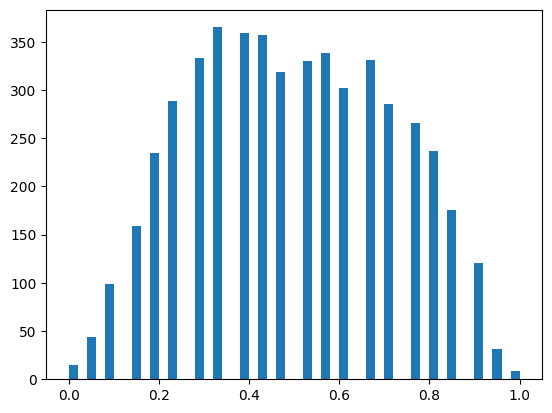

In [14]:
# plot the null distribution:
plt.hist(null_distribuiton, bins=50)
plt.show()

## bootstrapping

In [ ]:
def bootstrapping(netmats, groups, classifier=None, sample_size=10):
    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    # sample with replacement
    sample_indices = np.random.choice(netmats.shape[0], size=(sample_size), replace=True)
    # now accordingly do the sampling from the netmats and labels:
    sample_netmats = netmats[sample_indices]
    sample_labels = labels[sample_indices]
    
    
    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    loo = LeaveOneOut()

    predictions = np.zeros(sample_labels.shape, dtype=int)    

    for fold, (train, test) in enumerate(loo.split(sample_netmats)):

        test_label   = sample_labels[test[0]]
        train_labels = [sample_labels[i] for i in train]

        # Suppress this warning:
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(sample_netmats[train], train_labels)
            result = pipe.predict(sample_netmats[test])[0]

        predictions[fold] = result


    correct  = (sample_labels == predictions).sum()
    accuracy = correct / len(sample_labels)
    
    return float(accuracy)
    # predictions = pipe.predict(netmats)

def run_many_bootstraps(netmats, groups, observed_accuracy_threshold, classifier=None, sample_size=10, n_simulations=1000):
    print (f'\n>>>>>>>>>>>>>>>>>> Bootstrapping for sample size: {sample_size} with classifier: {classifier} <<<<<<<<<<<<<<<<<<')
    accuracies = []
    for i in range(n_simulations):
        if i % 10 == 0:
            print(f'>>> Simulation: {i}')
        accuracy = bootstrapping(netmats, groups, classifier=classifier, sample_size=sample_size)
        accuracies.append(float(accuracy))
    power = sum([1 for acc in accuracies if acc > observed_accuracy_threshold]) / n_simulations
    return power

behav_var = 'any_test_DTH_slips'
behav_data, ts_completely_concat, Fnetmats_completely_concat, Pnetmats_completely_concat, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, n_ICs=50)
# power = run_many_bootstraps(Fnetmats_completely_concat, (n_0s, n_1s), observed_accuracy_threshold, classifier=DecisionTreeClassifier(random_state=123), sample_size=40, n_simulations=100)

sim_sample_size_range = range(10, 53, 3)
Ns = [n for n in sim_sample_size_range]
Powers = [run_many_bootstraps(Fnetmats_completely_concat, (n_0s, n_1s), observed_accuracy_threshold, classifier=DecisionTreeClassifier(random_state=123), sample_size=sim_sample_size, n_simulations=1000) for sim_sample_size in sim_sample_size_range]




>>>>>>>>>>>>>>>>>> Bootstrapping for sample size: 10 with classifier: DecisionTreeClassifier(random_state=123) <<<<<<<<<<<<<<<<<<
>>> Simulation: 0
>>> Simulation: 10
>>> Simulation: 20
>>> Simulation: 30
>>> Simulation: 40
>>> Simulation: 50
>>> Simulation: 60
>>> Simulation: 70
>>> Simulation: 80
>>> Simulation: 90
>>> Simulation: 100
>>> Simulation: 110
>>> Simulation: 120
>>> Simulation: 130
>>> Simulation: 140
>>> Simulation: 150
>>> Simulation: 160
>>> Simulation: 170
>>> Simulation: 180
>>> Simulation: 190
>>> Simulation: 200
>>> Simulation: 210
>>> Simulation: 220
>>> Simulation: 230
>>> Simulation: 240
>>> Simulation: 250
>>> Simulation: 260
>>> Simulation: 270
>>> Simulation: 280
>>> Simulation: 290
>>> Simulation: 300
>>> Simulation: 310
>>> Simulation: 320
>>> Simulation: 330
>>> Simulation: 340
>>> Simulation: 350
>>> Simulation: 360
>>> Simulation: 370
>>> Simulation: 380
>>> Simulation: 390
>>> Simulation: 400
>>> Simulation: 410
>>> Simulation: 420
>>> Simulation: 430


In [ ]:
# Save to pickle the results (null distribution, the observed accuracy, observed accuracy threshold, sim_sample_size_range, Ns, Powers):
import pickle
with open(f'./Power_analysis_{behav_var}_DecisionTreeClassifier.pkl', 'wb') as f:
    pickle.dump([null_distribuiton, accuracy, observed_accuracy_threshold, sim_sample_size_range, Ns, Powers], f)

# # Load the pickle file:
# with open(f'{whole_network_path}/Power_analysis_{behav_var}_DecisionTreeClassifier.pkl', 'rb') as f:
#     null_distribuiton, accuracy, observed_accuracy_threshold, sim_sample_size_range, Ns, Powers = pickle.load(f)

In [19]:
sim_sample_size_range = range(10, 53, 3)
Ns = [n for n in sim_sample_size_range]
Ns

[10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52]

In [ ]:
run_many_bootstraps(Fnetmats_completely_concat, (n_0s, n_1s), observed_accuracy_threshold, classifier=DecisionTreeClassifier(random_state=123), sample_size=20, n_simulations=1000)


>>>>>>>>>>>>>>>>>> Bootstrapping for sample size: 20 with classifier: DecisionTreeClassifier(random_state=123) <<<<<<<<<<<<<<<<<<
>>> Simulation: 0
>>> Simulation: 10
>>> Simulation: 20
>>> Simulation: 30
>>> Simulation: 40
>>> Simulation: 50
>>> Simulation: 60
>>> Simulation: 70
>>> Simulation: 80
>>> Simulation: 90
>>> Simulation: 100
>>> Simulation: 110
>>> Simulation: 120
>>> Simulation: 130
>>> Simulation: 140
>>> Simulation: 150
>>> Simulation: 160
>>> Simulation: 170
>>> Simulation: 180
>>> Simulation: 190
>>> Simulation: 200
>>> Simulation: 210
>>> Simulation: 220
>>> Simulation: 230
>>> Simulation: 240
>>> Simulation: 250
>>> Simulation: 260
>>> Simulation: 270
>>> Simulation: 280
>>> Simulation: 290
>>> Simulation: 300
>>> Simulation: 310
>>> Simulation: 320
>>> Simulation: 330
>>> Simulation: 340
>>> Simulation: 350
>>> Simulation: 360
>>> Simulation: 370
>>> Simulation: 380
>>> Simulation: 390
>>> Simulation: 400
>>> Simulation: 410
>>> Simulation: 420
>>> Simulation: 430


In [105]:
behav_vars_if_interest = ['any_test_DTH_slips']


# get the data with subID and the behavior variable (and remove NaNs):
behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
# re-arange data to have all 1 in a row and all 0 in a row:
behav_data = behav_data.sort_values(by=[behav_var,'subID'], ascending=[True, True]).reset_index(drop=True)
n_0s = int((behav_data[behav_var] == 0).sum()) # Goal-directed
n_1s = int((behav_data[behav_var] == 1).sum()) # Habitual

# nruns = 1 if concatenate_sub_runs else 2
nruns = 1
## Load as the relevant data as a ts object:
relevant_files = [f'{by_IDCH_sub_ID_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
ts = nets.load(relevant_files, 0.70, varnorm=0, nruns=nruns, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
Fnetmats = nets.netmats(ts, 'corr',   True)
# sample with replacement n times:
n = 1000
n_samples = 100




assigning None to unbound local 'subj'
assigning None to unbound local 'subj'


In [107]:
ts

In [106]:
relevant_files

['/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_102.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_103.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_104.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_107.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_108.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_109.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_111.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_112.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_113.txt',
 '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/IC_ts_by_IDCH_sub_ID/dr_stage1_117.txt',
 '/export/home/ranigera/IDCH-r

In [74]:
def classify(netmats, groups, classifier=None, print_folds=True, print_only_when_better_than_majority_acc = True, shuffleLabels=False):
    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    if shuffleLabels:
        np.random.shuffle(labels)
        
    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    loo = LeaveOneOut()

    predictions = np.zeros(labels.shape, dtype=int)
    for fold, (train, test) in enumerate(loo.split(netmats)):

        test_label   =  labels[test[0]]
        train_labels = [labels[i] for i in train]

        # Suppress this warning:
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(netmats[train], train_labels)
            result = pipe.predict(netmats[test])[0]

        predictions[fold] = result

        if print_folds:
            print(f'Training fold {fold+1:2d} label: {test_label}, prediction: {result}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)
    
    majority_class_acc = max(np.bincount(labels)) / sum(np.bincount(labels))
    if print_only_when_better_than_majority_acc and accuracy <= majority_class_acc:
        return accuracy
    print(f'-------------------------------------- >  Accuracy during cross-validation: {100 * accuracy:0.2f}% [majority class accuracy: {100 * majority_class_acc:0.2f}%]')
    return accuracy
    # predictions = pipe.predict(netmats)
    # correct     = (labels == predictions).sum()
    # accuracy    = correct / len(labels)
    # print(f'Accuracy on input data:   {100 * accuracy:0.2f}%')


In [73]:
behav_vars_of_interest = ['any_test_DTH_slips']
print (f'\n>>>>>>>>>>>>>>>>>> Classifier: {DecisionTreeClassifier()} <<<<<<<<<<<<<<<<<<')
for behav_var in behav_vars_of_interest:
    # behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, n_ICs=n_ICs)
    behav_data, ts_completely_concat, Fnetmats_completely_concat, Pnetmats_completely_concat, n_0s, n_1s = prepare_for_permutation_test(main_behav_data, behav_var, n_ICs=n_ICs)
    print(f'---------------------------------   {behav_var}   ---------------------------------')
    # print(f'>>> Partial corr (regular, leave one time series out, include all others, including the participants)')
    # classify(Pnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
    # print(f'>>> Full corr (regular, leave one time series out, include all others, including the participants)')
    # classify(Fnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
    # print(f'>>> Partial corr (time series per subject completely concatenated)')
    # classify(Pnetmats_completely_concat, (n_0s, n_1s), classifier=DecisionTreeClassifier(), print_folds=False)
    print(f'>>> Full corr (time series per subject completely concatenated)')
    classify(Fnetmats_completely_concat, (n_0s, n_1s), classifier=DecisionTreeClassifier(), print_folds=False)



>>>>>>>>>>>>>>>>>> Classifier: DecisionTreeClassifier() <<<<<<<<<<<<<<<<<<


KeyboardInterrupt: 

In [28]:
n_0s

12

# Next:
- Decide on parcellatino and add dimensionality reduction

For the univariate analysis:
- maybe also use less components.
- mayb use only hypothesized components/regions.
- Maybe clean the data and throw away bad components (clean up) [many of the last ones afre so good]
